# Coding Discussion 6
Rosey Cao

## Instructions
Building off what we did in lecture this week, please build a model that predicts the log selling price of a house in DC (PRICE). Please use what you’ve learned of the sklearn library to accomplish this task.

I’ve split this dataset into a training and test dataset (so you don’t need to split it on your own). Using the training data, build a model that predicts the price of a residential unit in District of Columbia.

You may use any feature in the dataset to generate a model. Some things to keep in mind:

- Be sure to predict the log Price, not the raw Price
- Be sure to pre-process your data.
- Be careful of missing data values. You can do whatever you like with them.
- Try different models, some algorithms perform better on a specific data outcome than others.
- Be sure to tune your model (if it has relevant tuning parameters).
- Once you’ve come up with a model that you think performs well, please test your model on the provided test data and report the mean squared error.

## Dependencies

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp
from sklearn.impute import SimpleImputer # Process missing data
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.linear_model import Ridge

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## Data
DC housing data. Here we wish to do some EDA.

### EDA & Pre-Processing

In [2]:
# Read in train and test data set
train = pd.read_csv('../train_data.csv')
test = pd.read_csv('../test_data.csv')
train.shape, test.shape

((43590, 39), (14531, 39))

In [3]:
# Available features
train.columns

Index(['OBJECTID', 'SSL', 'BATHRM', 'HF_BATHRM', 'HEAT', 'HEAT_D', 'AC',
       'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES',
       'SALEDATE', 'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE',
       'STYLE_D', 'STRUCT', 'STRUCT_D', 'GRADE', 'GRADE_D', 'CNDTN', 'CNDTN_D',
       'EXTWALL', 'EXTWALL_D', 'ROOF', 'ROOF_D', 'INTWALL', 'INTWALL_D',
       'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM',
       'LN_PRICE'],
      dtype='object')

In [4]:
# Head
train.head(5)

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


OBJECTID                 0
SSL                      0
BATHRM                   1
HF_BATHRM                2
HEAT                     1
HEAT_D                   1
AC                       1
NUM_UNITS                1
ROOMS                   11
BEDRM                    4
AYB                      4
YR_RMDL              18583
EYB                      0
STORIES                 29
SALEDATE                 0
QUALIFIED                0
SALE_NUM                 0
GBA                      0
BLDG_NUM                 0
STYLE                    1
STYLE_D                  1
STRUCT                   1
STRUCT_D                 1
GRADE                    1
GRADE_D                  1
CNDTN                    1
CNDTN_D                  1
EXTWALL                  1
EXTWALL_D                1
ROOF                     1
ROOF_D                   1
INTWALL                  1
INTWALL_D                1
KITCHENS                 2
FIREPLACES               1
USECODE                  0
LANDAREA                 0
G

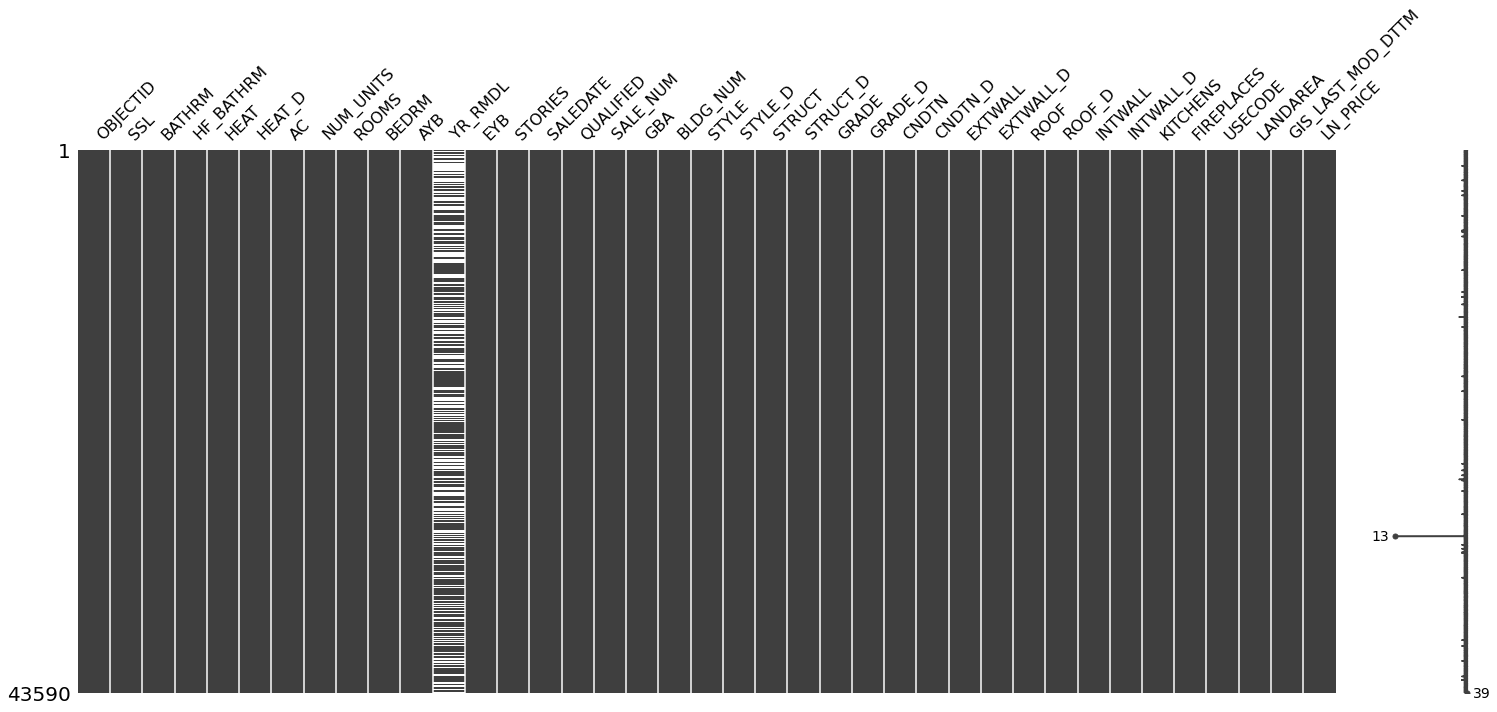

In [5]:
miss.matrix(train)
train.isna().sum()

In [6]:
# Drop all observations where the outcome is missing 
train = train[~train.LN_PRICE.isna()]
test = test[~test.LN_PRICE.isna()]

# Only houses that are sold
train = train[train.LN_PRICE > 0]
test = test[test.LN_PRICE > 0]


# Only land area > 0
train = train[train.LANDAREA > 0]
test = test[test.LANDAREA > 0]

#Properly drop NA
train = train.drop("YR_RMDL", axis = 1)
train = train.dropna()

test = test.drop("YR_RMDL", axis = 1)
test = test.dropna()

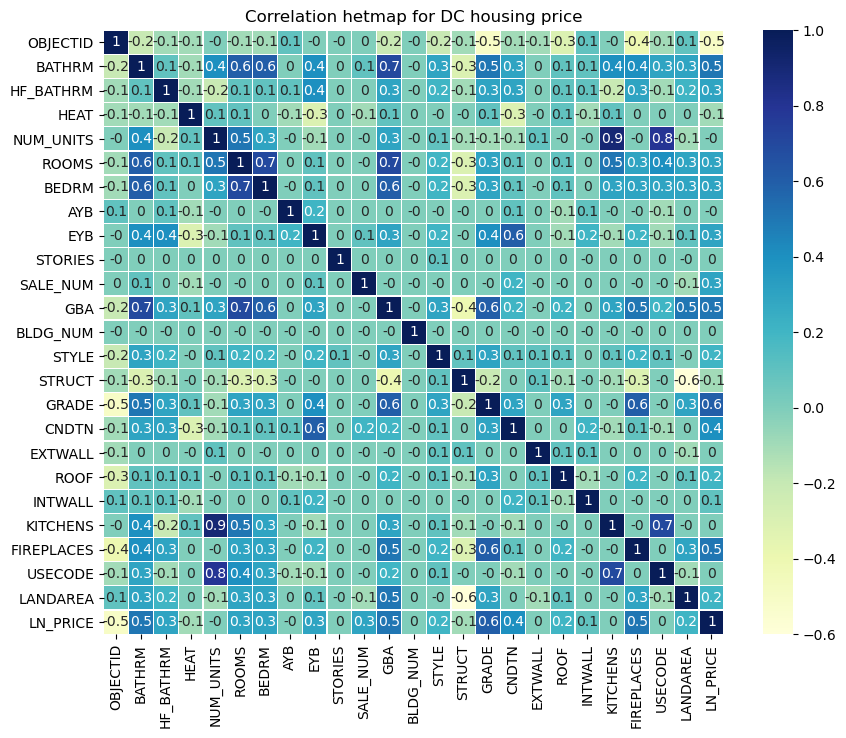

In [7]:
# Correlation heatmap to select variables
plt.figure(figsize=(10,8), dpi=100)
plt.title("Correlation hetmap for DC housing price")
sns.heatmap(train.corr().round(1),cmap="YlGnBu",annot=True,linewidths=.2)
plt.show()

In [8]:
# Select features
selected_features = ['BATHRM','ROOMS','GBA','GRADE','FIREPLACES','LANDAREA']

In [9]:
# Create trainig and test data set
train_X = train[selected_features]
test_X = test[selected_features]

train_y =train['LN_PRICE']
test_y =test['LN_PRICE']

In [10]:
train_X['LANDAREA'] = np.log(train_X['LANDAREA'])
test_X['LANDAREA'] = np.log(test_X['LANDAREA'])

In [11]:
train_X.shape

(43540, 6)

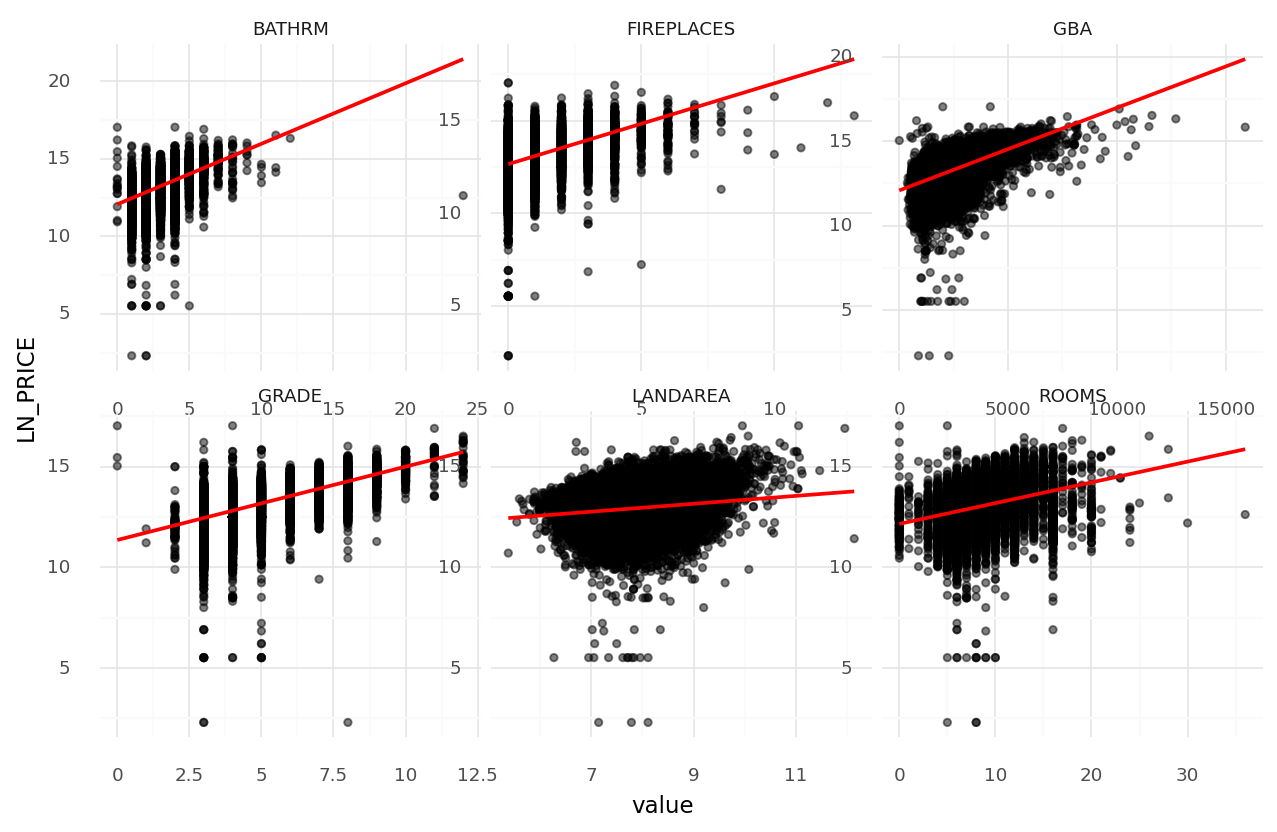

<ggplot: (8785439119607)>

In [12]:
# Visualization: Again, don't know what went wrong... Jitter is not working
D = train_X.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5, position = "jitter") +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,6),dpi=150) 
)

In [13]:
train_X.describe().round(2)

,BATHRM,ROOMS,GBA,GRADE,FIREPLACES,LANDAREA
count,43540.00,43540.00,43540.00,43540.00,43540.00,43540.00
mean,2.20,7.42,1723.59,4.30,0.64,7.80
std,1.07,2.33,823.69,1.37,0.91,0.68
min,0.00,0.00,0.00,0.00,0.00,5.38
25%,1.00,6.00,1212.00,3.00,0.00,7.33
50%,2.00,7.00,1500.00,4.00,0.00,7.70
75%,3.00,8.00,1980.00,5.00,1.00,8.29
max,24.00,36.00,15902.00,12.00,13.00,12.14


### Pre-Processing

In [14]:
# Scale
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [15]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,ROOMS,GBA,GRADE,FIREPLACES,LANDAREA
0,0.125000,0.250000,0.079235,0.416667,0.000000,0.345337
1,0.083333,0.194444,0.089674,0.500000,0.076923,0.425790
2,0.083333,0.250000,0.142749,0.500000,0.076923,0.531400
3,0.041667,0.166667,0.080367,0.250000,0.000000,0.375461
4,0.083333,0.305556,0.184631,0.416667,0.000000,0.335982
...,...,...,...,...,...,...
43535,0.041667,0.138889,0.061250,0.333333,0.076923,0.140818
43536,0.083333,0.194444,0.100805,0.416667,0.076923,0.284773
43537,0.083333,0.250000,0.152056,0.333333,0.153846,0.275519
43538,0.125000,0.166667,0.090680,0.333333,0.076923,0.207292


## Modeling
- Linear Regression 
- KNN
- Decision Trees
- Bagging 
- Random Forest
- Lasso

In [16]:
# Generate folds
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

In [17]:
# Metrics
use_metrics = ["neg_mean_squared_error"]

In [18]:
# Lm
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [19]:
#KNN
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [20]:
#Decision tree
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

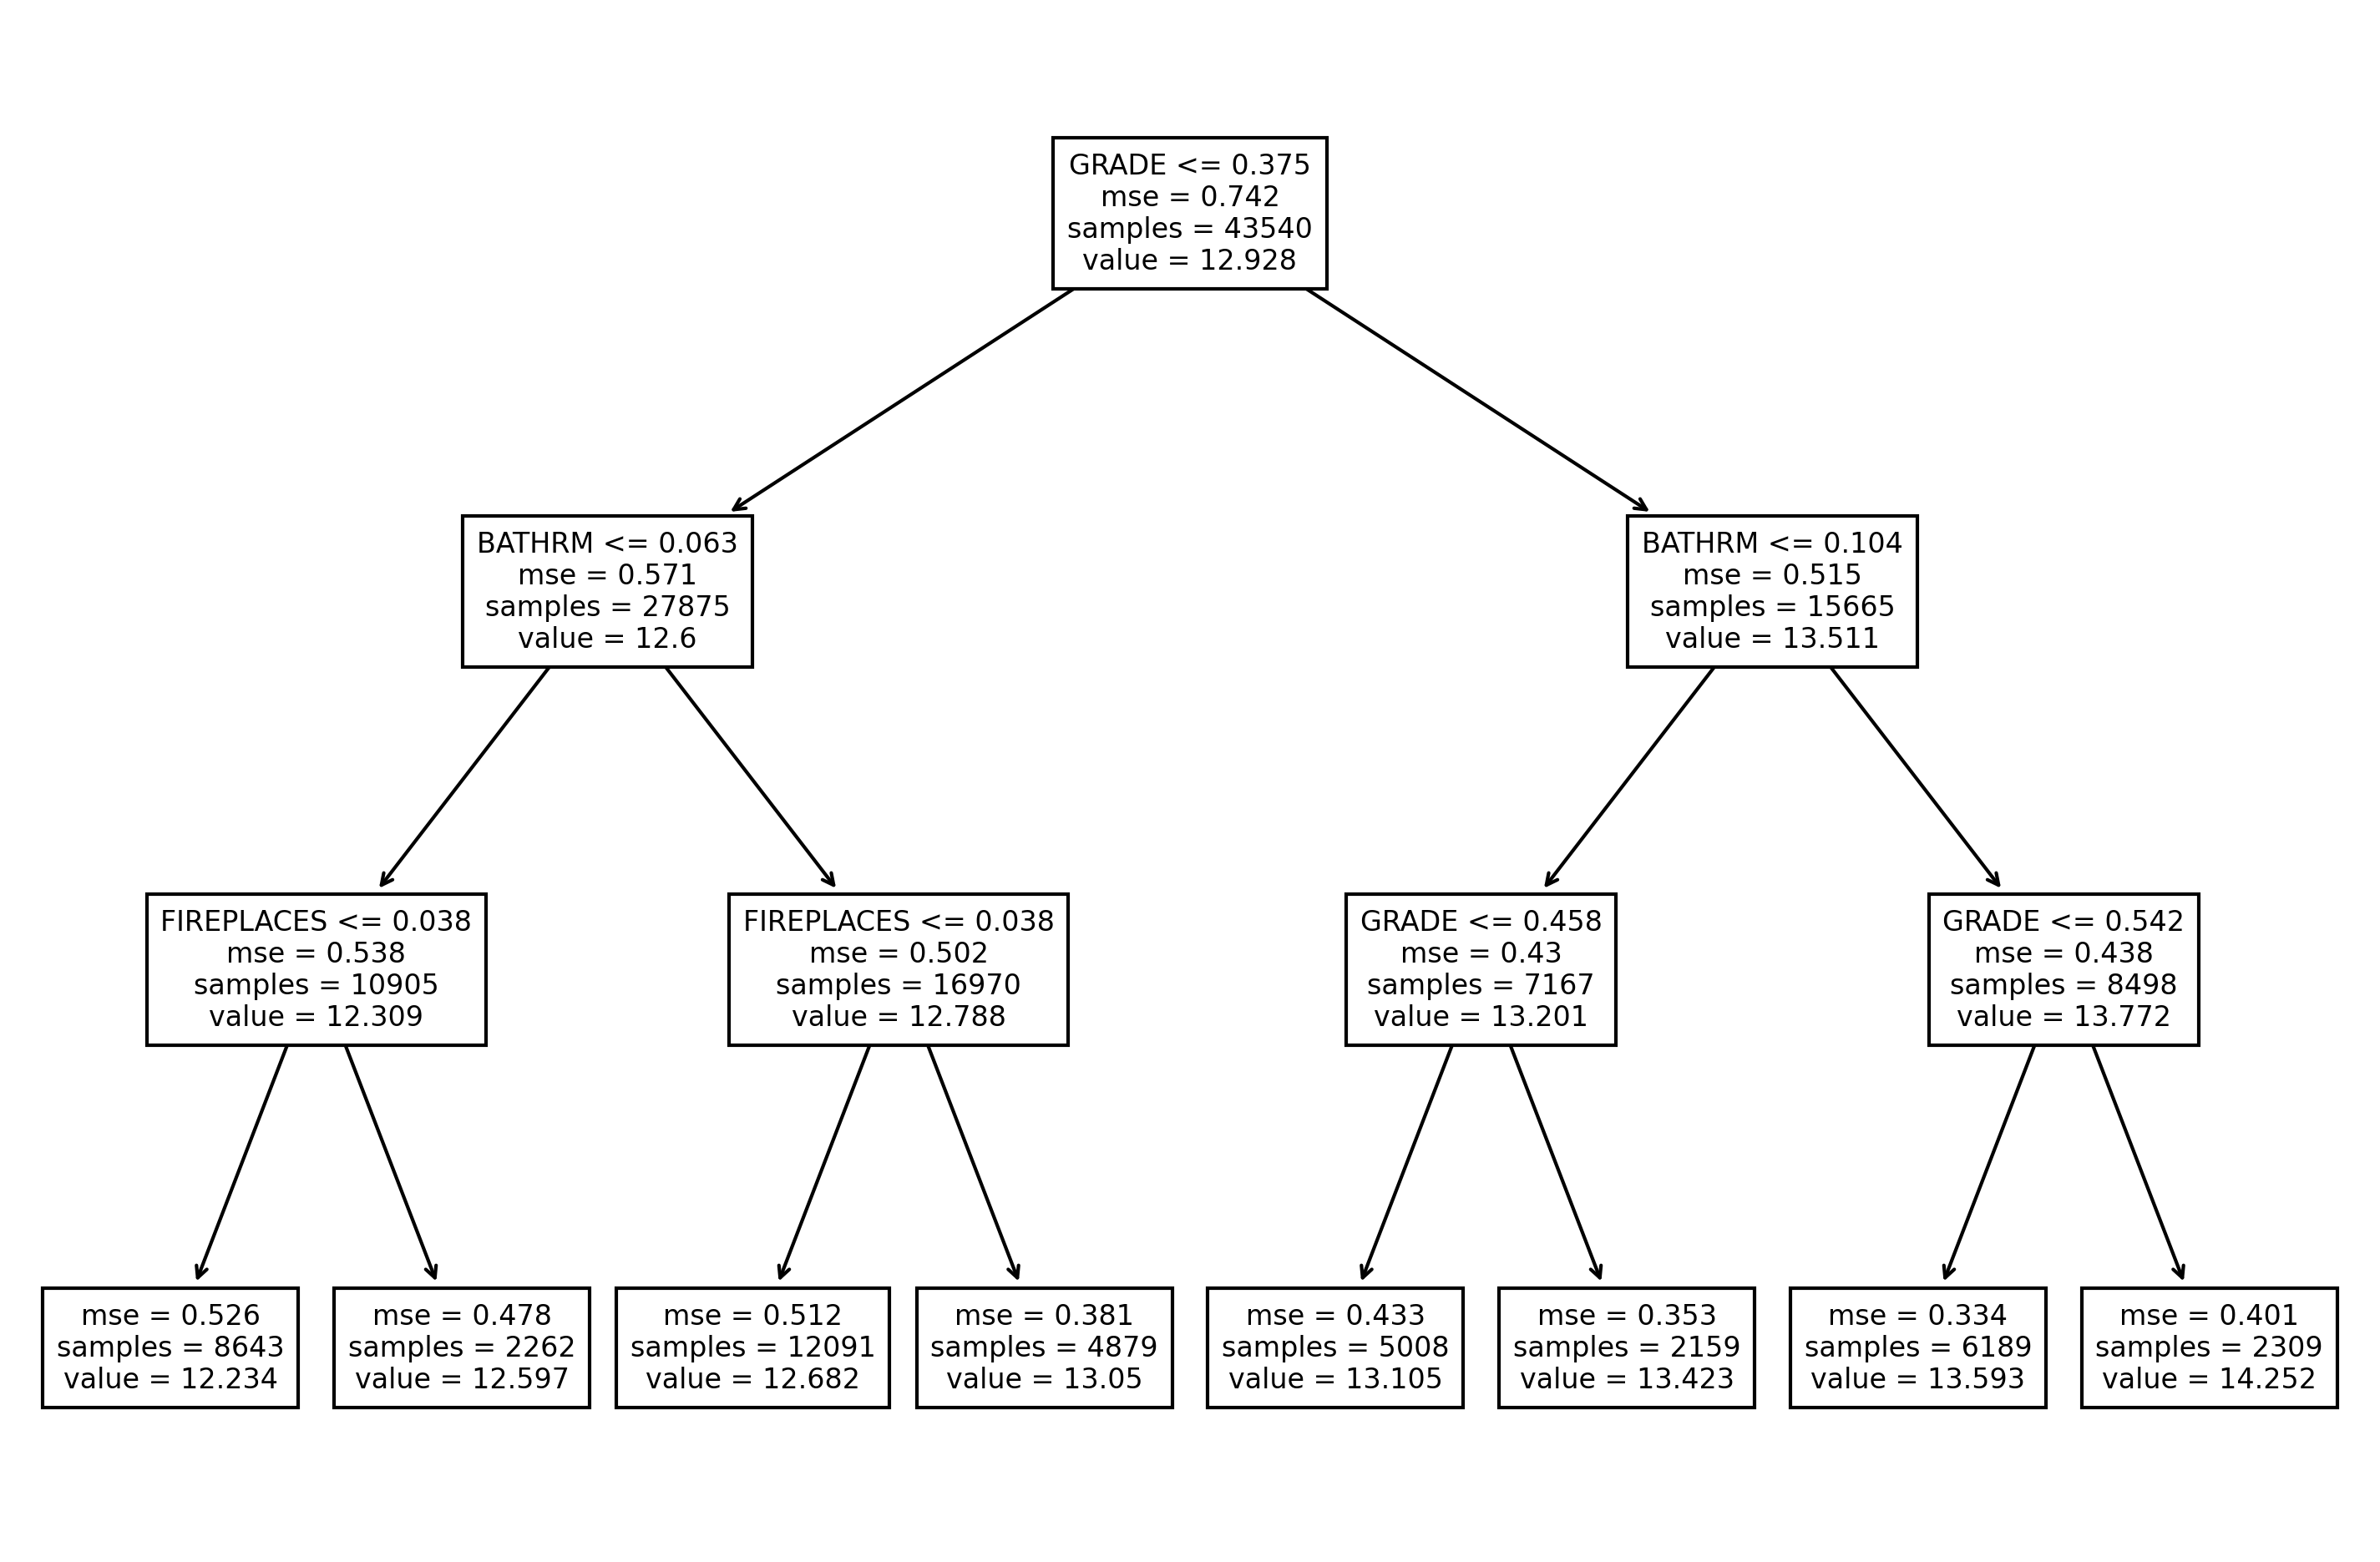

In [21]:
#Visualize tree
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

In [22]:
# Bage
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [23]:
# Random forest
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [24]:
# Ridge
ridge_scores = cross_validate(Ridge(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [25]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1,
     ridge = ridge_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")

In [26]:
collect_scores

,Model,MSE
0,lm,0.437412
1,lm,0.421997
2,lm,0.438882
3,lm,0.429075
4,lm,0.422781
5,knn,0.460392
6,knn,0.447035
7,knn,0.460476
8,knn,0.457678
9,knn,0.449120


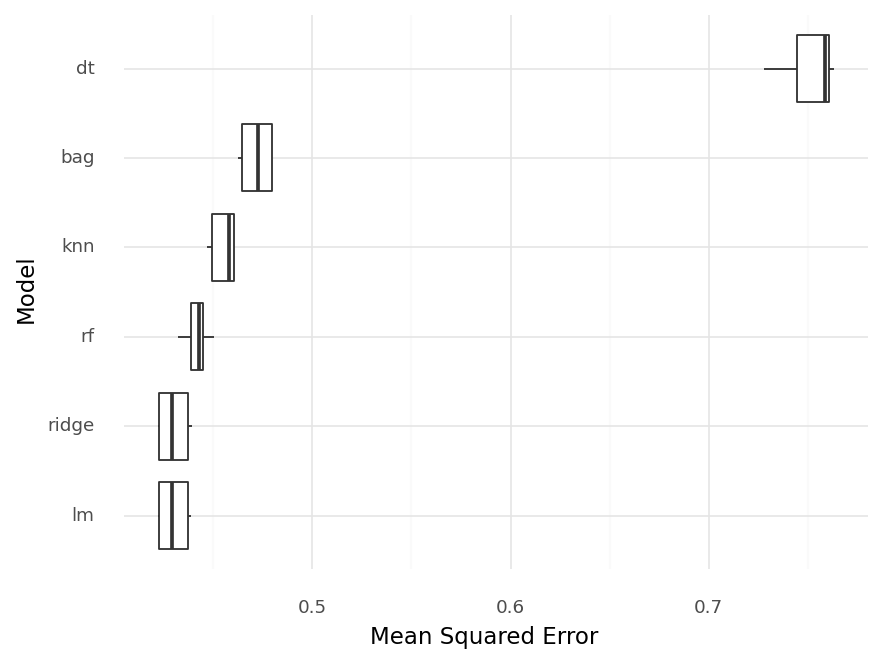

<ggplot: (8785437725898)>

In [27]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

In [28]:
#lm does the best here.

## Modeling Pipeline

In [29]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), selected_features)])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,15,20,25]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
    
    # Ridge regression with the alpha tuning param
    {'model' : [Ridge()],
     'model__alpha': [0.25,0.5,0.75,1]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'GBA',
                                                                          'GRADE',
                                                                          'FIREPLACES',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_ne

In [30]:
search.best_score_ # Mean out-of-sample (CV) error

-0.40555699068204315

In [31]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=25), 'model__n_neighbors': 25}

## Test Performance
I really don't know what's wrong here....

In [41]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [42]:
m.mean_squared_error(test_y,pred_y)

6.642983579963895

In [43]:
m.r2_score(test_y,pred_y)

-7.9898667319232075

In [44]:
test_X.describe()

,BATHRM,ROOMS,GBA,GRADE,FIREPLACES,LANDAREA
count,14513.000000,14513.000000,14513.000000,14513.00000,14513.000000,14513.000000
mean,2.205402,7.442293,1727.996899,4.30297,0.647006,7.805045
std,1.063213,2.475402,826.376516,1.37410,0.923277,0.677027
min,0.000000,0.000000,252.000000,2.00000,0.000000,5.802118
25%,1.000000,6.000000,1216.000000,3.00000,0.000000,7.327781
50%,2.000000,7.000000,1510.000000,4.00000,0.000000,7.711101
75%,3.000000,8.000000,1990.000000,5.00000,1.000000,8.294050
max,10.000000,101.000000,15673.000000,12.00000,13.000000,11.536056


In [46]:
test_y.describe()

,LN_PRICE
count,14513.000000
mean,12.927534
std,0.859647
min,2.302585
25%,12.388394
50%,12.984824
75%,13.527828
max,16.991908


In [49]:
pred_y

array([[15.35667475],
       [15.35667475],
       [15.35667475],
       ...,
       [15.35667475],
       [15.35667475],
       [15.35667475]])